In [115]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

# lat_a=0.0871
lat_a=0.08852707268831382
lat_NL=64; lat_NT=96
lat_L=lat_a*lat_NL
hbarc = 1/197.327
lat_aInv=1/(lat_a*hbarc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
def symmetrize(dat):
    dat_bw=np.roll(np.flip(dat,axis=1),1,axis=1)
    return((dat[:,:,0]+dat[:,:,5]) - (dat_bw[:,:,10]+dat_bw[:,:,15]))/4

d_jk=1
Nsrc=100
path=f'/capstor/store/cscs/userlab/lp139/lyan/code/projectData/03_NpiScatteringWilson/MILC_a09m130W/data_merge/NpiScatteringWilson_Nsrc={Nsrc}.h5'
data={}
with h5py.File(path) as f:    
    cfgs_all=[cfg.decode() for cfg in f['cfgs'][:]]
    # cfgs_map=[cfgs_all.index(cfg) for cfg in cfgs]
    
    if True:
        cfgs_map=[cfgs_all.index(cfg) for cfg in cfgs_all]
        
    for cont in f['data'].keys():
        if cont in ['N']:
            t=f[f'data/{cont}'][:,:,16]
            t=symmetrize(t)
            data[cont]=yu.jackknife(t[cfgs_map],d=d_jk)
            continue
        if cont in ['P']:
            t=f[f'data/{cont}'][:,:,0]
            t_bw=np.roll(np.flip(t,axis=1),1,axis=1)
            t=(t+t_bw)/2
            data[cont]=yu.jackknife(t[cfgs_map],d=d_jk)
            continue
        t=f[f'data/{cont}'][:,:,0]
        t=symmetrize(t)
        data[cont]=yu.jackknife(t[cfgs_map],d=d_jk)

# Nucleon 2pt function

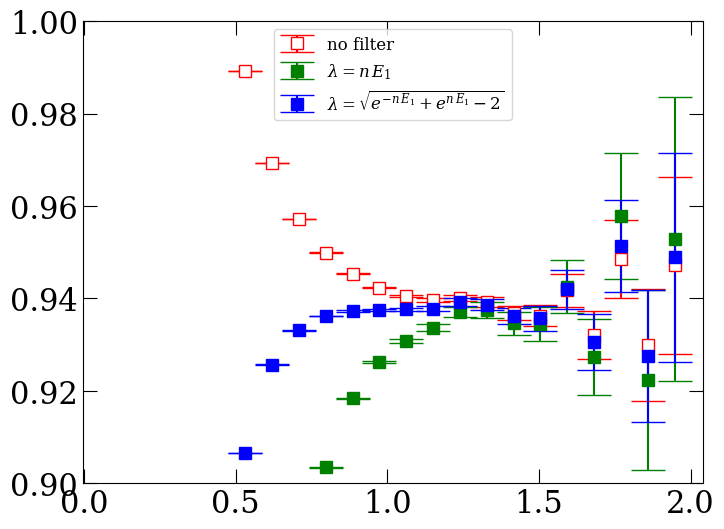

In [138]:
# toy model

Njk=400
amN=938/lat_aInv
amN1=2000/lat_aInv
amN2=3000/lat_aInv
c0=1; rc1=1; rc2=1

ts=np.arange(0,96)

c2pt=np.array([c0*( np.exp(-amN*ts) + rc1 * np.exp(-amN1*ts) + rc2 * np.exp(-amN2*ts) )]*Njk)

def contaminate(dat):
    error=1/lat_aInv * 1e-3
    shape=dat.shape
    t=yu.jackknife(np.random.randn(*shape)*error*np.sqrt(shape[0]))
    return dat+t
c2pt=contaminate(c2pt)

c2pt2meff=lambda c:np.log(c/np.roll(c,-1))
meff=yu.jackmap(c2pt2meff,c2pt)

fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=8)
ax=axs[0,0]
xunit=lat_a; yunit=lat_aInv/1000
tmin=1;tmax=23
ax.set_ylim([0.9,1])

mean,err=yu.jackme(meff)
plt_x=ts[tmin:tmax]*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r',mfc='white',label='no filter')

def applyLaplacianFilter(c,lbd,n):
    return -(np.roll(c,n) + np.roll(c,-n) - 2*c) + lbd**2 * c

n=4
lbd0=amN1*n
lbd=lbd0
tc2pt=[applyLaplacianFilter(c,lbd,n) for c in c2pt]
tmeff=yu.jackmap(c2pt2meff,tc2pt)
mean,err=yu.jackme(tmeff)
plt_x=ts[tmin:tmax]*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g',label=r'$\lambda=n\,E_1$')

lbd0=amN1*n
lbd=np.sqrt(np.exp(-lbd0)+np.exp(lbd0)-2)
tc2pt=[applyLaplacianFilter(c,lbd,n) for c in c2pt]
tmeff=yu.jackmap(c2pt2meff,tc2pt)
mean,err=yu.jackme(tmeff)
plt_x=ts[tmin:tmax]*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b',label=r'$\lambda=\sqrt{e^{-n\,E_1}+e^{n\,E_1}-2}$')

ax.legend(fontsize=12)

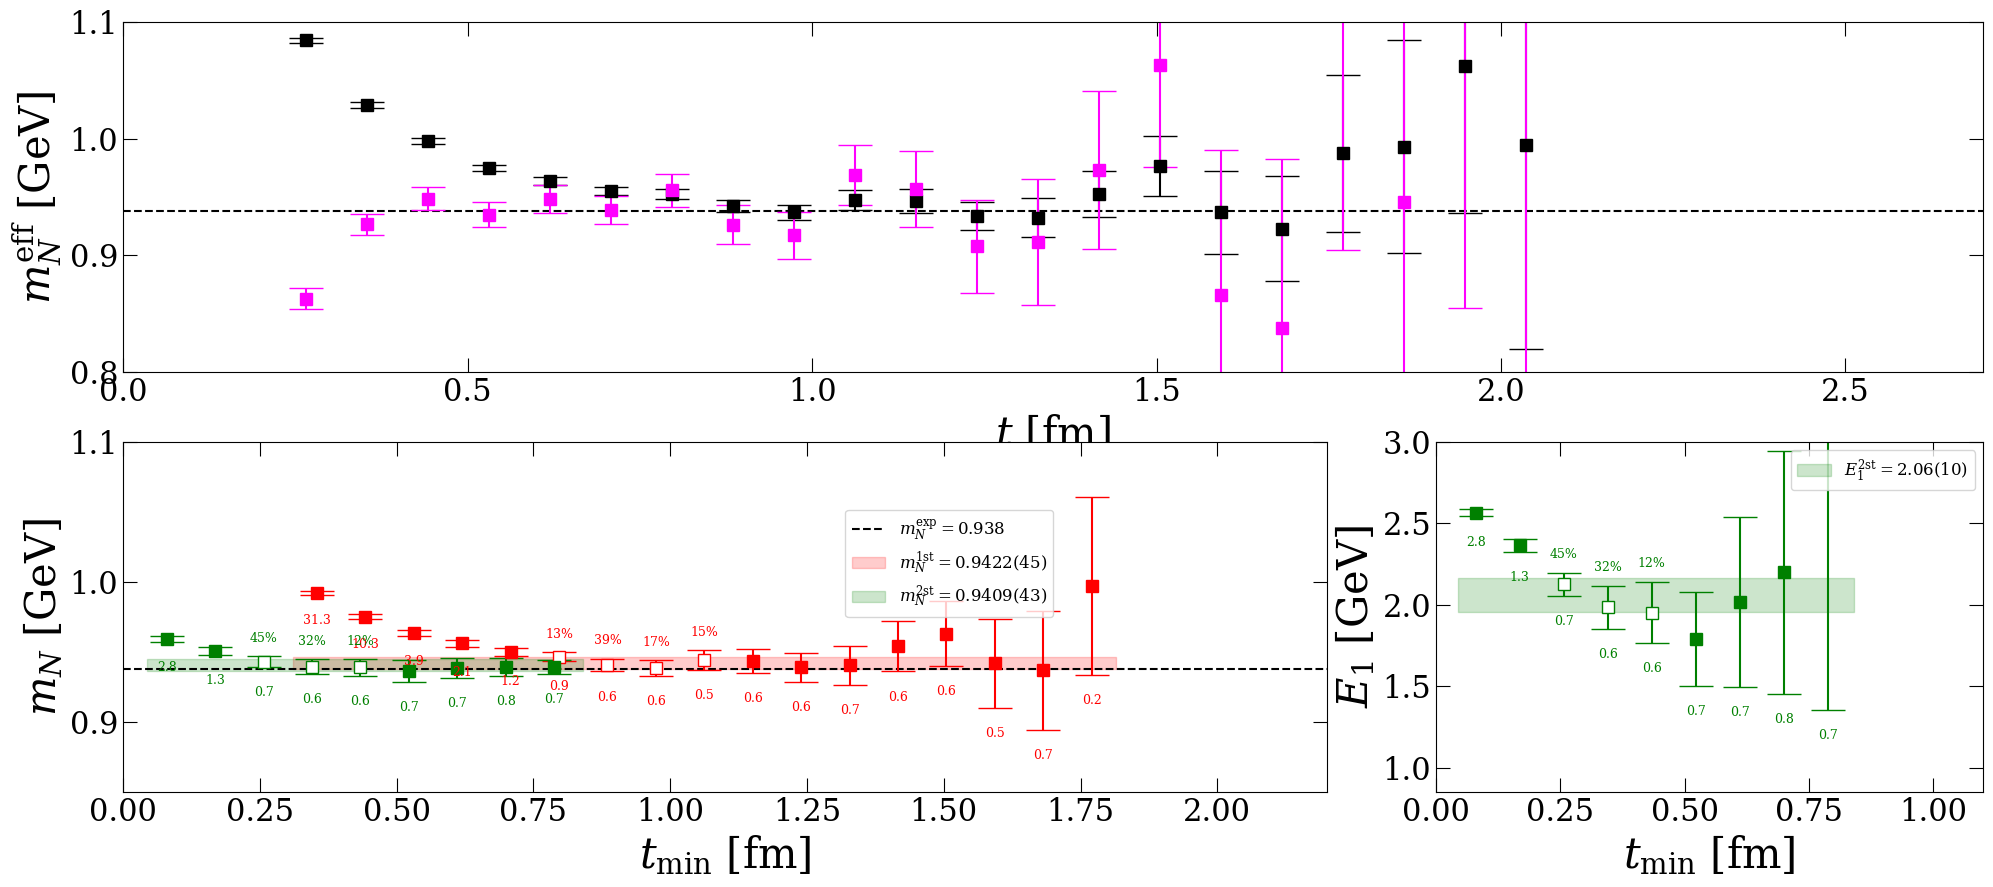

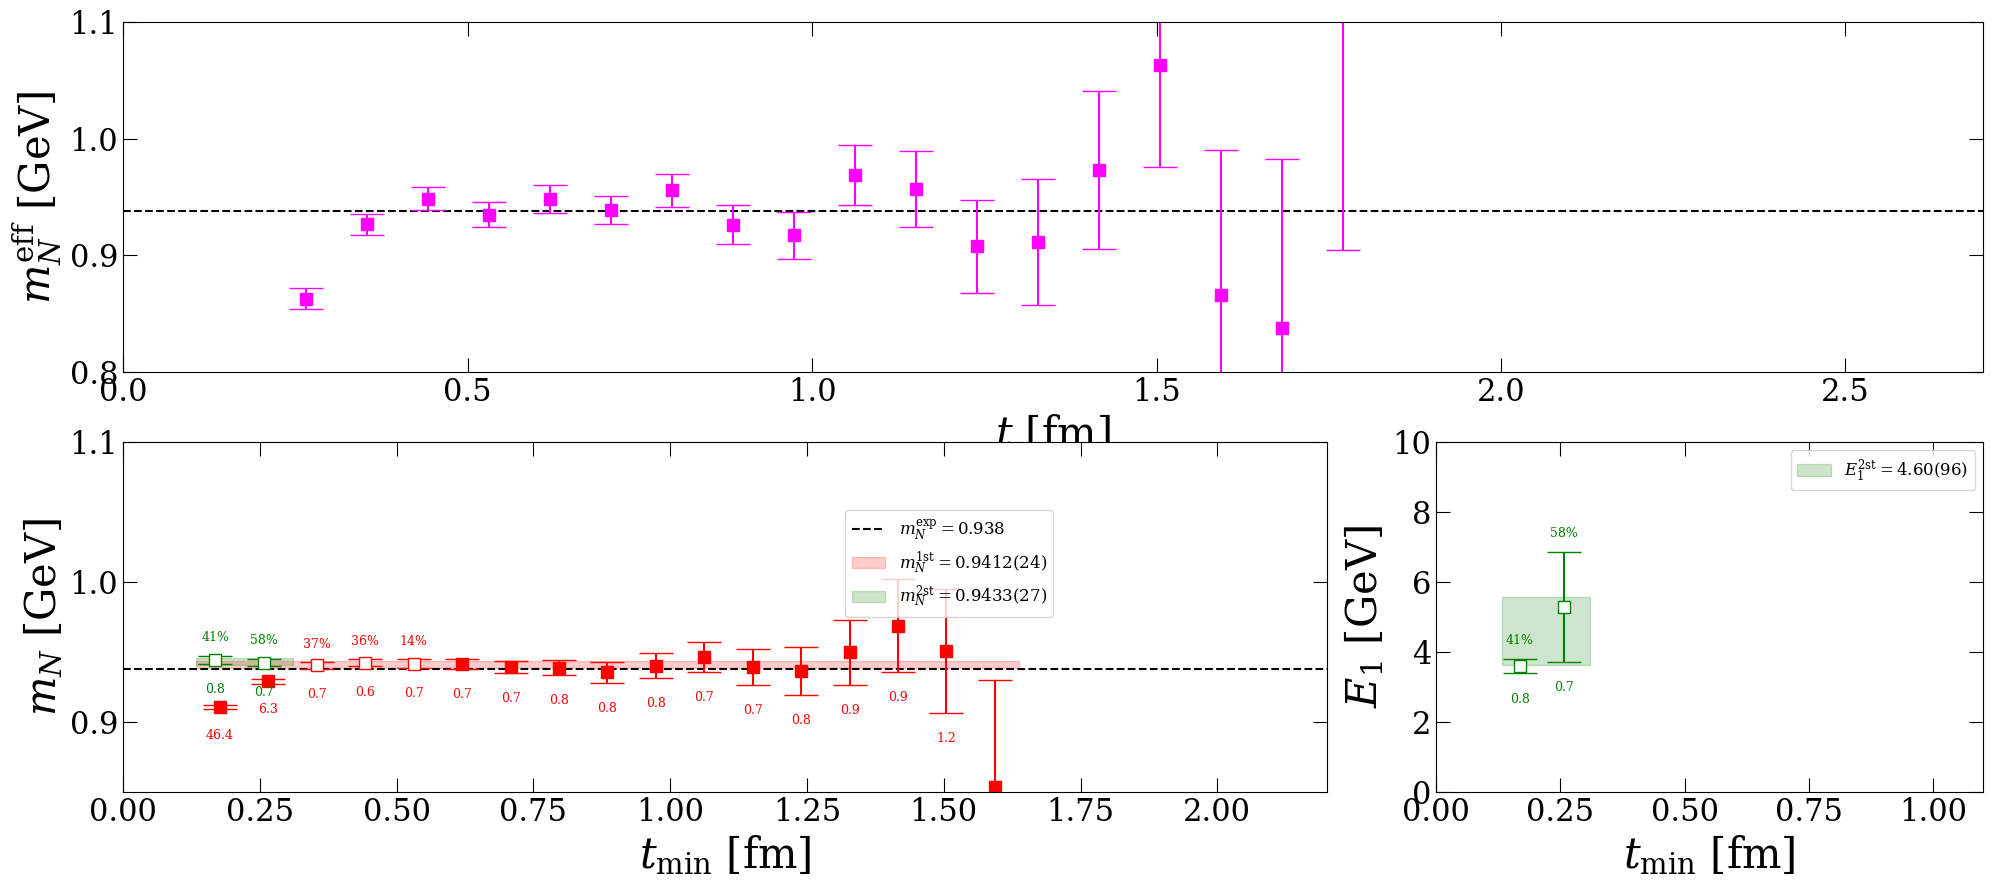

In [133]:
settings={
    'fitmins_1st':range(4,20+1),
    'fitmins_2st':range(1,9+1),
    'fitmins_3st':range(1,4+1),
    'ylim1':[0.8,1.1],
    'ylim2':[0.85,1.1],
    'ylim3':[0.85,3.0],
    'xlim1':[0,2.7],
    'xlim2':[0,2.2],
    'xlim3':[0,1.1],
}

m_N=None

propThreshold=0.1

func=lambda c:np.log(c/np.roll(c,-1))
meff_N=yu.jackmap(func,np.real(data['N']))

func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

xUnit=xunit=lat_a; yUnit=yunit=lat_aInv/1000
fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(24,10))
(ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])
chi2Size=9
ax1.set_xlabel(r'$t$ [fm]')
ax2.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
ax3.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
ax1.set_ylabel(r'$m_N^{\mathrm{eff}}$ [GeV]')
ax2.set_ylabel(r'$m_N$ [GeV]')
ax3.set_ylabel(r'$E_1$ [GeV]')
ax1.set_ylim(settings['ylim1'])
ax2.set_ylim(settings['ylim2'])
ax3.set_ylim(settings['ylim3'])
ax1.set_xlim(settings['xlim1'])
ax2.set_xlim(settings['xlim2'])
ax3.set_xlim(settings['xlim3'])

mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
ax1.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
ax2.axhline(y=mN_exp,color='black',linestyle = '--', marker='', label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)

mEff_jk=meff_N
(mEff_mean,mEff_err)=yu.jackme(mEff_jk)
mEff_rela=np.abs(mEff_err/mEff_mean)
temp=[(i,rela) for i,rela in enumerate(mEff_rela) if rela>0.2 and i!=0]
fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1

tmin=1; tmax=fitmax+1
plt_x=np.arange(tmin,tmax)*xUnit; plt_y=mEff_mean[tmin:tmax]*yUnit; plt_err=mEff_err[tmin:tmax]*yUnit
ax1.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')

meffQ=True; corrQ=True; C2pt_jk=None

pars0_initial=[0.4,0.5,1,2,0.1] if meffQ else [0.4,1e-8,0.5,2,0.8,1]
DNpar=1 if meffQ else 0

fits_all=[]
# 1st fits
color='r'
fitmins=settings['fitmins_1st']
pars0=pars0_initial[:2-DNpar]
fits=[]
for fitmin in fitmins:
    tList=np.arange(fitmin,fitmax)
    def fitfunc(pars):
        if meffQ:
            return func_mEff_1st(tList,*pars)
        return func_C2pt_1st(tList,*pars)
    y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
    pars0=np.mean(pars_jk,axis=0)
    fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    fits_all.append([('1st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    
pars_jk,props_jk=yu.jackMA(fits)
mfits1st_N=pars_jk[:,0]
props_mean=np.mean(props_jk,axis=0)
# for i,prop in enumerate(np.mean(props_jk,axis=0)):
#     if prop<0.1:
#         continue
#     fitmin,t_pars_jk,chi2_jk,Ndof=fits[i]
#     print(i,prop,fitmin*xUnit,np.mean(t_pars_jk,axis=0)[0]*yUnit,np.mean(chi2_jk)/Ndof,np.mean(chi2_jk),Ndof)
ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
pars_mean,pars_err=yu.jackme(pars_jk)
pars0=pars_mean
plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2,label=r'$m_N^{\mathrm{1st}}=$'+yu.un2str(plt_y,plt_err))
for i,fit in enumerate(fits):
    fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
    (pars_mean,pars_err)=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof
    showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
    
    plt_x=fitmin*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
    ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
    ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    if propThreshold is not None and prop>propThreshold:
        ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
# 2st fits
color='g'
fitmins=settings['fitmins_2st']
pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
fits=[]
for fitmin in fitmins:
    tList=np.arange(fitmin,fitmax)
    def fitfunc(pars):
        if meffQ:
            return func_mEff_2st(tList,*pars)
        return func_C2pt_2st(tList,*pars)
    y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
    pars0=np.mean(pars_jk,axis=0)
    # print('2st',fitmin,np.mean(chi2_jk)/Ndof,pars0)
    fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    fits_all.append([('2st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
pars_jk,props_jk=yu.jackMA(fits)
mfits2st_N=pars_jk[:,0]
props_mean=np.mean(props_jk,axis=0)
pars0=yu.jackme(pars_jk)[0]
res=pars_jk.copy()
ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
pars_mean,pars_err=yu.jackme(pars_jk)
plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[1]*yUnit; plt_err=pars_err[1]*yUnit
ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))

res_E1=pars_mean[1]

mean,err=pars_mean,pars_err

for i,fit in enumerate(fits):
    fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
    # print(fitmin,np.mean(pars_jk,axis=0))
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    (pars_mean,pars_err)=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof
    showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
    
    plt_x=(fitmin-0.1)*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
    ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
    ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    if propThreshold is not None and prop>propThreshold:
        ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
    
    plt_x=(fitmin-0.1)*xUnit; plt_y=pars_mean[1]*yUnit; plt_err=pars_err[1]*yUnit
    ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
    ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    if propThreshold is not None and prop>propThreshold:
        ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
# # 3st fits
# color='b'
# fitmins=settings['fitmins_3st']
# pars0=np.hstack([pars0,pars0_initial[4-DNpar:6-DNpar]])
# fits=[]
# for fitmin in fitmins:
#     # print(3,fitmin)
#     tList=np.arange(fitmin,fitmax)
#     def fitfunc(pars):
#         if meffQ:
#             return func_mEff_3st(tList,*pars)
#         return func_C2pt_3st(tList,*pars)
#     y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
#     pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
#     pars0=np.mean(pars_jk,axis=0)
#     fits.append([fitmin,pars_jk,chi2_jk,Ndof])
#     print('3st',fitmin,np.mean(chi2_jk)/Ndof,pars0)
#     fits_all.append([('3st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
# pars_jk,props_jk=yu.jackMA(fits)
# props_mean=np.mean(props_jk,axis=0)
# ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
# pars0=yu.jackme(pars_jk)[0]
# # print(pars0)
# pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
# pars_mean,pars_err=yu.jackme(pars_jk)
# # plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
# # ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))
# # plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
# # ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))    
# for i,fit in enumerate(fits):
#     fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
#     pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
#     (pars_mean,pars_err)=yu.jackme(pars_jk)
#     chi2R=np.mean(chi2_jk)/Ndof
#     showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
    
#     plt_x=(fitmin+0.1)*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
#     ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
#     ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
#     ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
#     if propThreshold is not None and prop>propThreshold:
#         ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
    
#     plt_x=(fitmin+0.1)*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
#     ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
#     ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
#     ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
#     if propThreshold is not None and prop>propThreshold:
#         ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
# color='orange'
# pars_jk,props_jk=yu.jackMA(fits_all)
# ind_mpf=np.argmax(np.mean(props_jk,axis=0))
# pars_mean,pars_err=yu.jackme(pars_jk)
# plt_x=settings['xlim2']; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{nst}}=$'+yu.un2str(plt_y,plt_err) + f'; MPF: {fits_all[ind_mpf][0][0]}')    

ax2.legend(loc=(0.6,0.5),fontsize=12)
ax3.legend(fontsize=12)


#### laplacian filter ####
n=1
lbd0=(2000/lat_aInv)*n
lbd0=res_E1*n
lbd=lbd0
lbd=np.sqrt(np.exp(-lbd0)+np.exp(lbd0)-2)
tc2pt=[applyLaplacianFilter(c,lbd,n) for c in np.real(data['N'])]
tmeff=yu.jackmap(c2pt2meff,tc2pt)
mEff_jk=tmeff

(mEff_mean,mEff_err)=yu.jackme(mEff_jk)
plt_x=np.arange(tmin,tmax)*xUnit; plt_y=mEff_mean[tmin:tmax]*yUnit; plt_err=mEff_err[tmin:tmax]*yUnit
ax1.errorbar(plt_x,plt_y,plt_err,color='magenta',fmt='s')

settings={
    'fitmins_1st':range(1+n,19),
    'fitmins_2st':range(1+n,5-n),
    'ylim1':[0.8,1.1],
    'ylim2':[0.85,1.1],
    'ylim3':[0,10.0],
    'xlim1':[0,2.7],
    'xlim2':[0,2.2],
    'xlim3':[0,1.1],
}

fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(24,10))
(ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])
chi2Size=9
ax1.set_xlabel(r'$t$ [fm]')
ax2.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
ax3.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
ax1.set_ylabel(r'$m_N^{\mathrm{eff}}$ [GeV]')
ax2.set_ylabel(r'$m_N$ [GeV]')
ax3.set_ylabel(r'$E_1$ [GeV]')
ax1.set_ylim(settings['ylim1'])
ax2.set_ylim(settings['ylim2'])
ax3.set_ylim(settings['ylim3'])
ax1.set_xlim(settings['xlim1'])
ax2.set_xlim(settings['xlim2'])
ax3.set_xlim(settings['xlim3'])

mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
ax1.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
ax2.axhline(y=mN_exp,color='black',linestyle = '--', marker='', label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)


(mEff_mean,mEff_err)=yu.jackme(mEff_jk)
mEff_rela=np.abs(mEff_err/mEff_mean)
temp=[(i,rela) for i,rela in enumerate(mEff_rela) if rela>0.2 and i!=0]
fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1

tmin=1; tmax=fitmax+1
plt_x=np.arange(tmin,tmax)*xUnit; plt_y=mEff_mean[tmin:tmax]*yUnit; plt_err=mEff_err[tmin:tmax]*yUnit
ax1.errorbar(plt_x,plt_y,plt_err,color='magenta',fmt='s')

meffQ=True; corrQ=True; C2pt_jk=None

pars0_initial=[0.4,1.18,1,3,1] if meffQ else [0.4,1e-8,0.5,2,0.8,1]
DNpar=1 if meffQ else 0

fits_all=[]
# 1st fits
color='r'
fitmins=settings['fitmins_1st']
pars0=pars0_initial[:2-DNpar]
fits=[]
for fitmin in fitmins:
    tList=np.arange(fitmin,fitmax)
    def fitfunc(pars):
        if meffQ:
            return func_mEff_1st(tList,*pars)
        return func_C2pt_1st(tList,*pars)
    y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
    pars0=np.mean(pars_jk,axis=0)
    fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    fits_all.append([('1st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    
pars_jk,props_jk=yu.jackMA(fits)
mfits1st_N=pars_jk[:,0]
props_mean=np.mean(props_jk,axis=0)
# for i,prop in enumerate(np.mean(props_jk,axis=0)):
#     if prop<0.1:
#         continue
#     fitmin,t_pars_jk,chi2_jk,Ndof=fits[i]
#     print(i,prop,fitmin*xUnit,np.mean(t_pars_jk,axis=0)[0]*yUnit,np.mean(chi2_jk)/Ndof,np.mean(chi2_jk),Ndof)
ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
pars_mean,pars_err=yu.jackme(pars_jk)
pars0=pars_mean
plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2,label=r'$m_N^{\mathrm{1st}}=$'+yu.un2str(plt_y,plt_err))
for i,fit in enumerate(fits):
    fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
    (pars_mean,pars_err)=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof
    showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
    
    plt_x=fitmin*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
    ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
    ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    if propThreshold is not None and prop>propThreshold:
        ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
# 2st fits
color='g'
fitmins=settings['fitmins_2st']
pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
fits=[]
for fitmin in fitmins:
    tList=np.arange(fitmin,fitmax)
    def fitfunc(pars):
        if meffQ:
            return func_mEff_2st(tList,*pars)
        return func_C2pt_2st(tList,*pars)
    y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
    pars0=np.mean(pars_jk,axis=0)
    # print('2st',fitmin,np.mean(chi2_jk)/Ndof,pars0)
    fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    fits_all.append([('2st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
if(len(fits)>0):
    pars_jk,props_jk=yu.jackMA(fits)
    mfits2st_N=pars_jk[:,0]
    props_mean=np.mean(props_jk,axis=0)
    pars0=yu.jackme(pars_jk)[0]
    res=pars_jk.copy()
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[1]*yUnit; plt_err=pars_err[1]*yUnit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))

    mean,err=pars_mean,pars_err

    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        # print(fitmin,np.mean(pars_jk,axis=0))
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=(fitmin-0.1)*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=(fitmin-0.1)*xUnit; plt_y=pars_mean[1]*yUnit; plt_err=pars_err[1]*yUnit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
            
    ax3.legend(fontsize=12)            

ax2.legend(loc=(0.6,0.5),fontsize=12)

None

# apply on the ratio $\frac{c_{N\pi}}{c_N\,c_\pi}$

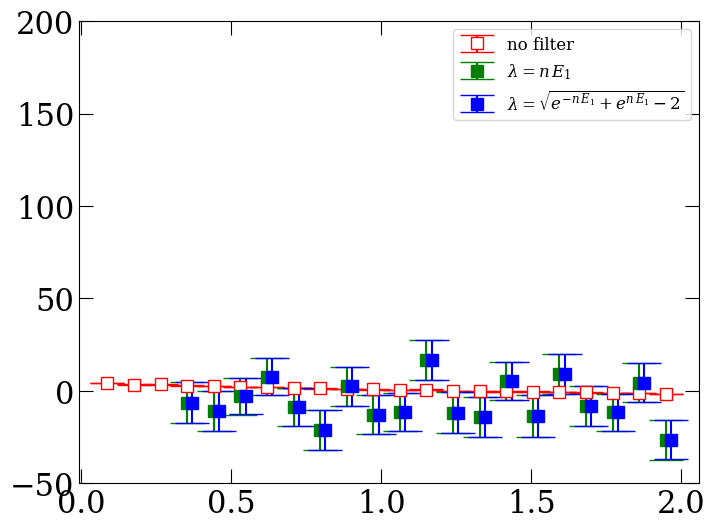

In [119]:
# toy model

Njk=400
amN=-5/lat_aInv
amN1=100/lat_aInv
amN2=200/lat_aInv
c0=1; rc1=0.1; rc2=0

ts=np.arange(0,96)


c2pt=np.array([c0*( np.exp(-amN*ts) + rc1 * np.exp(-amN1*ts) + rc2 * np.exp(-amN2*ts) )]*Njk)

def contaminate(dat):
    error=1/lat_aInv * 1e-1
    shape=dat.shape
    t=yu.jackknife(np.random.randn(*shape)*error*np.sqrt(shape[0]))
    return dat+t
c2pt=contaminate(c2pt)

c2pt2meff=lambda c:np.log(c/np.roll(c,-1))
meff=yu.jackmap(c2pt2meff,c2pt)

fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=8)
ax=axs[0,0]
xunit=lat_a; yunit=lat_aInv
tmin=1;tmax=23
ax.set_ylim([-50,200])

mean,err=yu.jackme(meff)
plt_x=ts[tmin:tmax]*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r',mfc='white',label='no filter')

def applyLaplacianFilter(c,lbd,n):
    return -(np.roll(c,n) + np.roll(c,-n) - 2*c) + lbd**2 * c

n=4
lbd0=amN1*n
lbd=lbd0
tc2pt=[applyLaplacianFilter(c,lbd,n) for c in c2pt]
tmeff=yu.jackmap(c2pt2meff,tc2pt)
mean,err=yu.jackme(tmeff)
plt_x=ts[tmin:tmax]*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g',label=r'$\lambda=n\,E_1$')

lbd0=amN1*n
lbd=np.sqrt(np.exp(-lbd0)+np.exp(lbd0)-2)
tc2pt=[applyLaplacianFilter(c,lbd,n) for c in c2pt]
tmeff=yu.jackmap(c2pt2meff,tc2pt)
mean,err=yu.jackme(tmeff)
plt_x=(ts[tmin:tmax]+0.2)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b',label=r'$\lambda=\sqrt{e^{-n\,E_1}+e^{n\,E_1}-2}$')

ax.legend(fontsize=12)

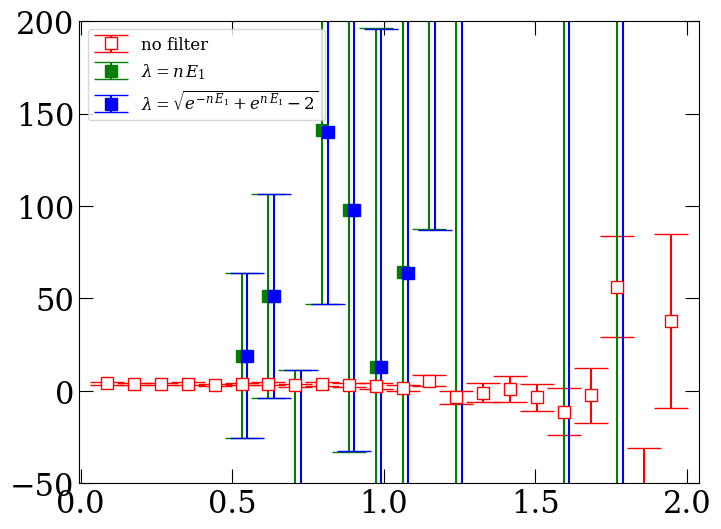

In [120]:
coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])


c2pt=c_32/(c_N*c_pi)

c2pt2meff=lambda c:np.log(c/np.roll(c,-1))
meff=yu.jackmap(c2pt2meff,c2pt)

fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=8)
ax=axs[0,0]
xunit=lat_a; yunit=lat_aInv
tmin=1;tmax=23
ax.set_ylim([-50,200])

mean,err=yu.jackme(meff)
plt_x=ts[tmin:tmax]*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r',mfc='white',label='no filter')

def applyLaplacianFilter(c,lbd,n):
    return -(np.roll(c,n) + np.roll(c,-n) - 2*c) + lbd**2 * c

n=5
lbd0=amN1*n
lbd=lbd0
tc2pt=[applyLaplacianFilter(c,lbd,n) for c in c2pt]
tmeff=yu.jackmap(c2pt2meff,tc2pt)
mean,err=yu.jackme(tmeff)
plt_x=ts[tmin:tmax]*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g',label=r'$\lambda=n\,E_1$')

lbd0=amN1*n
lbd=np.sqrt(np.exp(-lbd0)+np.exp(lbd0)-2)
tc2pt=[applyLaplacianFilter(c,lbd,n) for c in c2pt]
tmeff=yu.jackmap(c2pt2meff,tc2pt)
mean,err=yu.jackme(tmeff)
plt_x=(ts[tmin:tmax]+0.2)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b',label=r'$\lambda=\sqrt{e^{-n\,E_1}+e^{n\,E_1}-2}$')

ax.legend(fontsize=12)

# apply on the numerator/denominatro of the ratio $\frac{c_{N\pi}}{c_N\,c_\pi}$ 

In [121]:
# toy model

Njk=400
amN=938/lat_aInv
amN1=2000/lat_aInv
amN2=3000/lat_aInv
c0=1; rc1=1; rc2=1

ts=np.arange(0,96)

c2pt=np.array([c0*( np.exp(-amN*ts) + rc1 * np.exp(-amN1*ts) + rc2 * np.exp(-amN2*ts) )]*Njk)

def contaminate(dat):
    error=1/lat_aInv * 1e-3
    shape=dat.shape
    t=yu.jackknife(np.random.randn(*shape)*error*np.sqrt(shape[0]))
    return dat+t
c2pt=contaminate(c2pt)